In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

/home/kraigochieng/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def get_ml_model() -> BaseEstimator:
    """Load the trained ML model."""
    model_path = "ml_model_artifacts/model/model.pkl"
    return joblib.load(model_path)


def get_encoders() -> Tuple[OneHotEncoder, OrdinalEncoder]:
    """Load the one-hot and ordinal encoders."""
    encoders_path = "ml_model_artifacts/encoders"
    one_hot_encoder = joblib.load(f"{encoders_path}/one_hot_encoder.pkl")
    ordinal_encoder = joblib.load(f"{encoders_path}/ordinal_encoder.pkl")
    return one_hot_encoder, ordinal_encoder


def get_categorical_columns() -> List[str]:
    """Return list of categorical fields used for encoding."""
    return [
        "gender",
        "pregnancy_status",
        "known_allergy",
        "rechallenge",
        "dechallenge",
        "severity",
        "is_serious",
        "criteria_for_seriousness",
        "action_taken",
        "outcome",
    ]


def get_prediction_columns() -> List[str]:
    """Return list of columns used as prediction features after encoding."""
    return [
        "rechallenge_yes",
        "rechallenge_no",
        "rechallenge_unknown",
        "rechallenge_na",
        "dechallenge_yes",
        "dechallenge_no",
        "dechallenge_unknown",
        "dechallenge_na",
    ]

In [3]:
df = pd.read_csv("data.csv")
categorical_columns = get_categorical_columns()
one_hot_encoder, ordinal_encoder = get_encoders()
prediction_columns = get_prediction_columns()
ml_model = get_ml_model()

background_data_csv = "data.csv"
background_data_df = pd.read_csv(background_data_csv)
background_data_df = background_data_df[categorical_columns]

cat_encoded_background = one_hot_encoder.transform(background_data_df)
cat_encoded_background = pd.DataFrame(
    cat_encoded_background,
    columns=one_hot_encoder.get_feature_names_out(categorical_columns),
)

# Extract prediction input
# prediction_input = cat_encoded[prediction_columns]

background_data_for_prediction = cat_encoded_background[prediction_columns]
background_data_for_prediction = background_data_for_prediction.sample(frac=1)

/home/kraigochieng/miniconda3/envs/general/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kraigochieng/miniconda3/envs/general/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kraigochieng/miniconda3/envs/general/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator D

In [4]:
for i in range(10):
    print(
        ml_model.predict_proba(background_data_for_prediction)[i],
        np.array(ml_model.predict_proba(background_data_for_prediction)[i]).sum(),
    )

[0.16332813 0.16972845 0.16996932 0.16956321 0.16410707 0.16330381] 1.0
[0.16769426 0.17504733 0.1657562  0.16627423 0.16340083 0.16182715] 1.0
[0.16483465 0.16557386 0.16544018 0.16623266 0.16962391 0.16829474] 0.9999999999999999
[0.16483465 0.16557386 0.16544018 0.16623266 0.16962391 0.16829474] 0.9999999999999999
[0.16215172 0.16435522 0.17522597 0.1738636  0.16292513 0.16147837] 0.9999999999999999
[0.16483465 0.16557386 0.16544018 0.16623266 0.16962391 0.16829474] 0.9999999999999999
[0.16346331 0.16556912 0.16663389 0.16562728 0.16961905 0.16908736] 1.0
[0.16769426 0.17504733 0.1657562  0.16627423 0.16340083 0.16182715] 1.0
[0.16196776 0.16972196 0.17119407 0.16894407 0.16410079 0.16407134] 1.0
[0.16368003 0.16036412 0.17059076 0.17048258 0.16843581 0.1664467 ] 1.0


In [5]:
number_of_rows = 100

# Explain with SHAP
explainer = shap.KernelExplainer(
    ml_model.predict_proba,
    shap.kmeans(background_data_for_prediction[:number_of_rows], 10),
)
shap_values_yt = explainer(background_data_for_prediction[:number_of_rows])
shap_values = explainer.shap_values(background_data_for_prediction[:number_of_rows])
shap_values_first_row = explainer(background_data_for_prediction[:1])
# shap_values = explainer.shap_values(prediction_input)

100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


In [21]:
background_data_for_prediction[:1]

,rechallenge_yes,rechallenge_no,rechallenge_unknown,rechallenge_na,dechallenge_yes,dechallenge_no,dechallenge_unknown,dechallenge_na
383,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
shap_values.shape
print(np.sum(shap_values_first_row.values[0], axis=0))
print(np.sum(shap_values_first_row.values[0], axis=1))
print(shap_values_first_row.base_values[0])
print(np.sum(shap_values_first_row.values[0], axis=0) + shap_values_first_row.base_values[0])

[-0.00091416  0.00276006  0.00093702  0.00121493 -0.00217803 -0.00181981]
[-1.61587985e-05  5.64250581e-06 -9.46216447e-07  3.45565358e-06
  5.64250581e-06  5.64250581e-06  0.00000000e+00 -3.27815609e-06]
[0.16424229 0.1669684  0.16903231 0.16834828 0.16628511 0.16512362]
[0.16332813 0.16972845 0.16996932 0.16956321 0.16410707 0.16330381]


In [7]:
print(shap_values_yt.values[0,:,:])
print(shap_values_yt.base_values)

[[-2.83362692e-04  0.00000000e+00  6.46537108e-05  8.83157667e-05
   1.14234416e-04  0.00000000e+00]
 [-4.25310352e-04  2.04041524e-03  1.90696409e-03  1.63050587e-03
  -2.70094748e-03 -2.44598485e-03]
 [ 1.40662274e-04  0.00000000e+00  0.00000000e+00  1.14466844e-04
  -1.43195944e-04 -1.12879390e-04]
 [-1.65852286e-04  0.00000000e+00  1.69307939e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.20339379e-04 -1.10707664e-03  8.82449541e-04  6.88893208e-04
   1.49645587e-04  3.12070188e-04]
 [ 3.99218641e-04  1.82671761e-03 -1.78346501e-03 -1.46051339e-03
   4.02232461e-04  6.21452200e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.40827961e-04  0.00000000e+00 -3.02895024e-04  1.53259930e-04
   0.00000000e+00 -1.94471022e-04]]
[[0.16424229 0.1669684  0.16903231 0.16834828 0.16628511 0.16512362]
 [0.16424229 0.1669684  0.16903231 0.16834828 0.16628511 0.16512362]
 [0.16424229 0.1669684  0.16903231 0.16834828 0.16628

In [8]:
shap_values[0,:,:]

array([[-2.83362692e-04,  0.00000000e+00,  6.46537108e-05,
         8.83157667e-05,  1.14234416e-04,  0.00000000e+00],
       [-4.25310352e-04,  2.04041524e-03,  1.90696409e-03,
         1.63050587e-03, -2.70094748e-03, -2.44598485e-03],
       [ 1.40662274e-04,  0.00000000e+00,  0.00000000e+00,
         1.14466844e-04, -1.43195944e-04, -1.12879390e-04],
       [-1.65852286e-04,  0.00000000e+00,  1.69307939e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.20339379e-04, -1.10707664e-03,  8.82449541e-04,
         6.88893208e-04,  1.49645587e-04,  3.12070188e-04],
       [ 3.99218641e-04,  1.82671761e-03, -1.78346501e-03,
        -1.46051339e-03,  4.02232461e-04,  6.21452200e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.40827961e-04,  0.00000000e+00, -3.02895024e-04,
         1.53259930e-04,  0.00000000e+00, -1.94471022e-04]])

In [9]:
shap_row_softmax = softmax(shap_values[0])
shap_row_softmax

array([[0.12497885, 0.12495682, 0.12499338, 0.12499202, 0.12504827,
        0.12502839],
       [0.12496112, 0.12521204, 0.12522387, 0.12518493, 0.12469673,
        0.12472295],
       [0.12503186, 0.12495682, 0.1249853 , 0.12499529, 0.12501608,
        0.12501428],
       [0.12499354, 0.12495682, 0.12500646, 0.12498098, 0.12503398,
        0.12502839],
       [0.12489927, 0.12481856, 0.12509564, 0.12506711, 0.12505269,
        0.12506741],
       [0.12506419, 0.12518529, 0.12476259, 0.12479857, 0.12508429,
        0.12510611],
       [0.12501427, 0.12495682, 0.1249853 , 0.12498098, 0.12503398,
        0.12502839],
       [0.12505689, 0.12495682, 0.12494745, 0.12500013, 0.12503398,
        0.12500408]])

In [10]:
softmax(shap_values[0, :, :])

array([[0.12497885, 0.12495682, 0.12499338, 0.12499202, 0.12504827,
        0.12502839],
       [0.12496112, 0.12521204, 0.12522387, 0.12518493, 0.12469673,
        0.12472295],
       [0.12503186, 0.12495682, 0.1249853 , 0.12499529, 0.12501608,
        0.12501428],
       [0.12499354, 0.12495682, 0.12500646, 0.12498098, 0.12503398,
        0.12502839],
       [0.12489927, 0.12481856, 0.12509564, 0.12506711, 0.12505269,
        0.12506741],
       [0.12506419, 0.12518529, 0.12476259, 0.12479857, 0.12508429,
        0.12510611],
       [0.12501427, 0.12495682, 0.1249853 , 0.12498098, 0.12503398,
        0.12502839],
       [0.12505689, 0.12495682, 0.12494745, 0.12500013, 0.12503398,
        0.12500408]])

In [11]:
shap_values[0, :, :].sum(axis=0)

min_vals = np.min(
    shap_values[0, :, :].sum(axis=0)
)  # Minimum value for each feature (across instances/classes)
max_vals = np.max(
    shap_values[0, :, :].sum(axis=0)
)  # Maximum value for each feature (across instances/classes)

scaled_shap_values = 2 * (shap_values[0, :, :].sum(axis=0) - min_vals) / (max_vals - min_vals) - 1

print(shap_values[0, :, :].sum(axis=0))
print(scaled_shap_values)

[-0.00091416  0.00276006  0.00093702  0.00121493 -0.00217803 -0.00181981]
[-0.48811145  1.          0.26164083  0.3741998  -1.         -0.85491626]


In [12]:
shap_values[0,:,:].sum(axis=1)

array([-1.61587985e-05,  5.64250581e-06, -9.46216447e-07,  3.45565358e-06,
        5.64250581e-06,  5.64250581e-06,  0.00000000e+00, -3.27815609e-06])

In [13]:
def scale_shap_values_to_minus_1_1(shap_values):
    # Scale each feature in isolation across all instances and classes
    min_vals = np.min(shap_values, axis=(0, 1), keepdims=True)  # Minimum value for each feature (across instances/classes)
    max_vals = np.max(shap_values, axis=(0, 1), keepdims=True)  # Maximum value for each feature (across instances/classes)
    
    # Apply scaling to [-1, 1] range
    scaled_shap_values = 2 * (shap_values - min_vals) / (max_vals - min_vals) - 1
    
    return scaled_shap_values

# Example: Assuming shap_values has shape (100, 8, 6) for 100 instances, 8 features, and 6 classes
scaled_shap_values = scale_shap_values_to_minus_1_1(shap_values)
scaled_shap_values

array([[[-7.67900816e-01, -8.34040975e-02,  1.88405444e-04,
         -1.13366335e-02,  2.09816666e-02, -1.90242626e-02],
        [-8.12133056e-01,  4.48310083e-01,  5.44893936e-01,
          5.59428979e-01, -9.99594522e-01, -9.97671934e-01],
        [-6.35770608e-01, -8.34040975e-02, -1.89273930e-02,
         -1.65810193e-03, -7.23434912e-02, -6.41877280e-02],
        ...,
        [-5.55201986e-01,  3.92622369e-01, -5.46234447e-01,
         -5.84559364e-01,  1.25388400e-01,  2.29621083e-01],
        [-6.79602309e-01, -8.34040975e-02, -1.89273930e-02,
         -4.40223591e-02, -2.04312610e-02, -1.90242626e-02],
        [-5.73397077e-01, -8.34040975e-02, -1.08482658e-01,
          1.26992457e-02, -2.04312610e-02, -9.68328447e-02]],

       [[-7.68774823e-01, -7.90705056e-02,  2.00359952e-04,
         -1.12819509e-02,  2.11736202e-02, -1.90242626e-02],
        [-8.14091512e-01,  4.55039212e-01,  5.37723266e-01,
          5.53403745e-01, -9.97754726e-01, -9.93365597e-01],
        [-6.35267

In [14]:
mean_cls = np.abs(shap_values[:, :, 1]).mean(axis=0)

<BarContainer object of 8 artists>

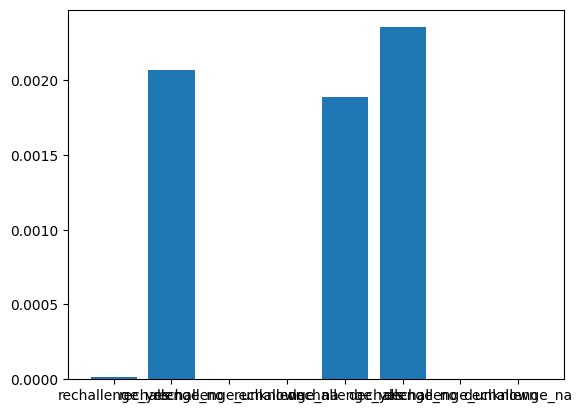

In [15]:
plt.bar(background_data_for_prediction.columns, mean_cls)

In [16]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0, :, 0],
    background_data_for_prediction.iloc[0, :],
)

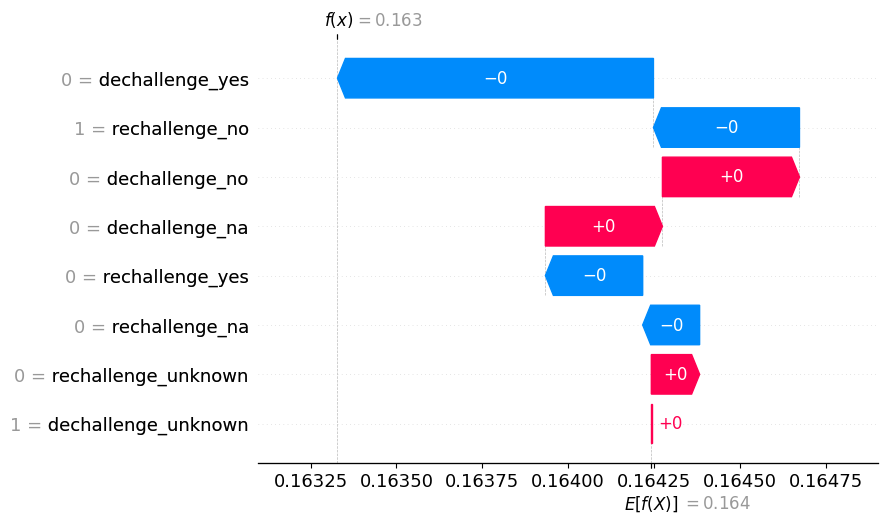

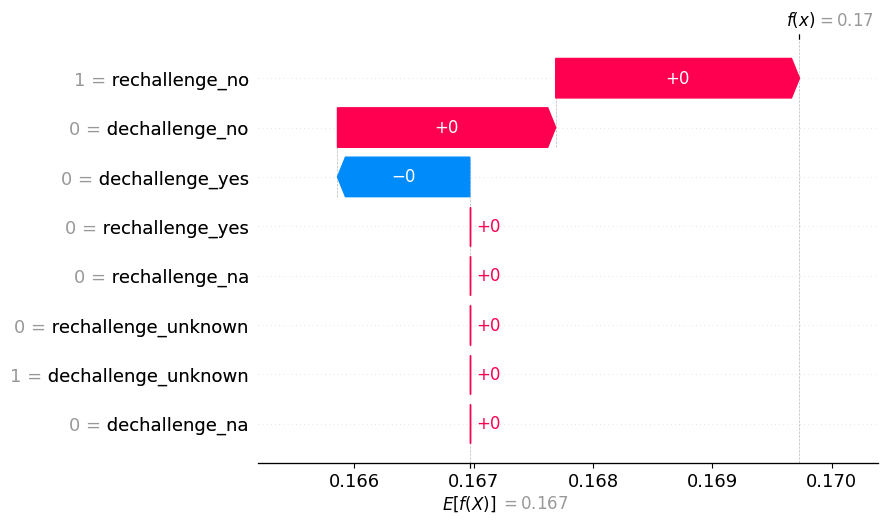

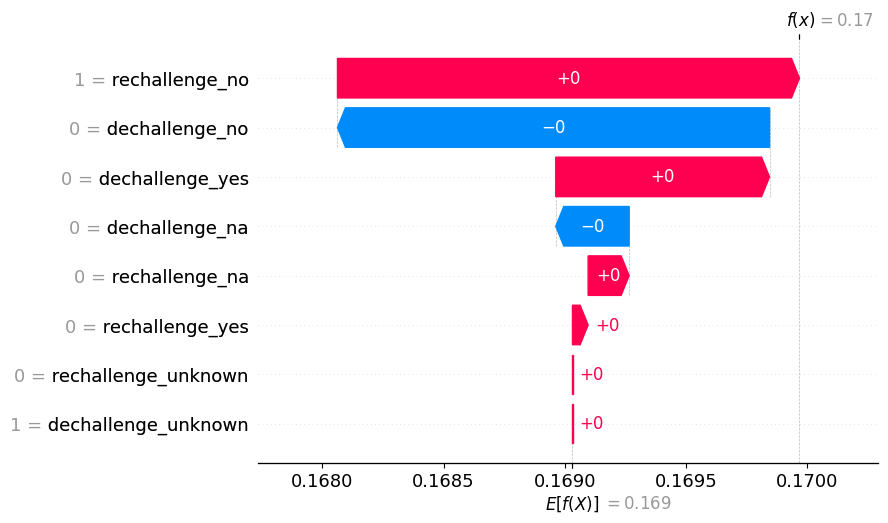

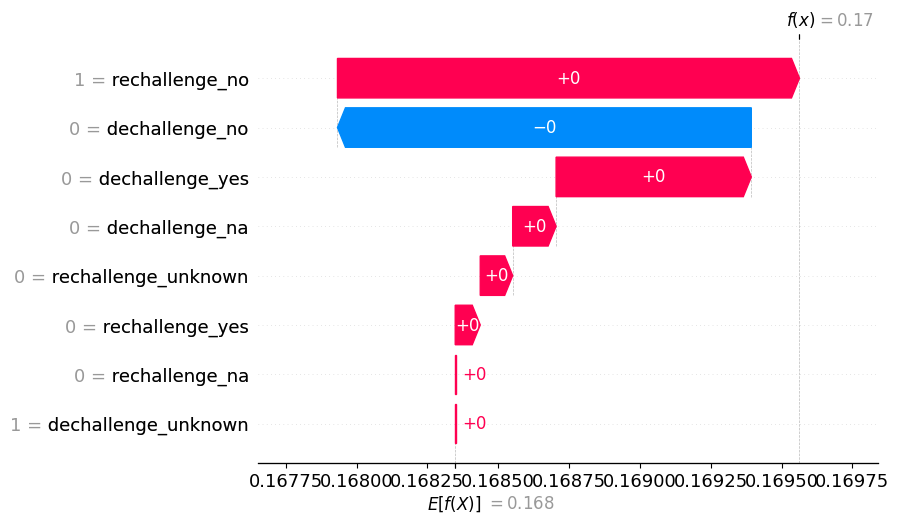

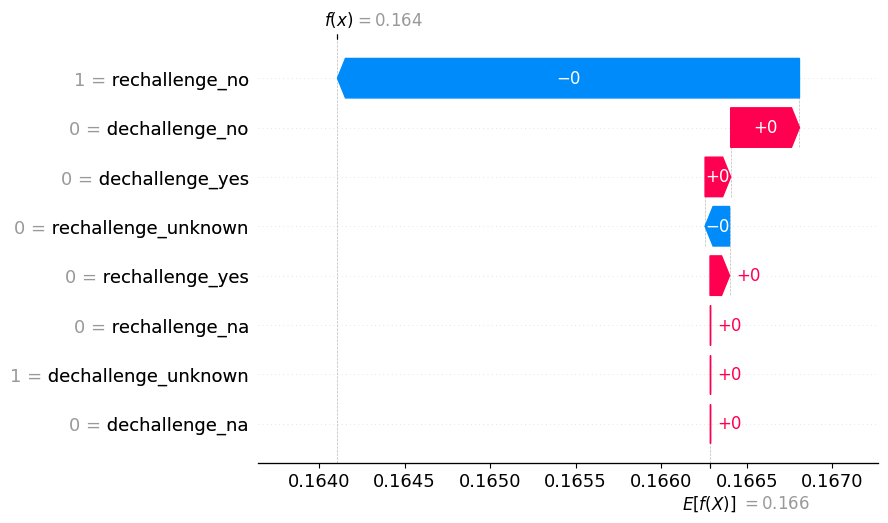

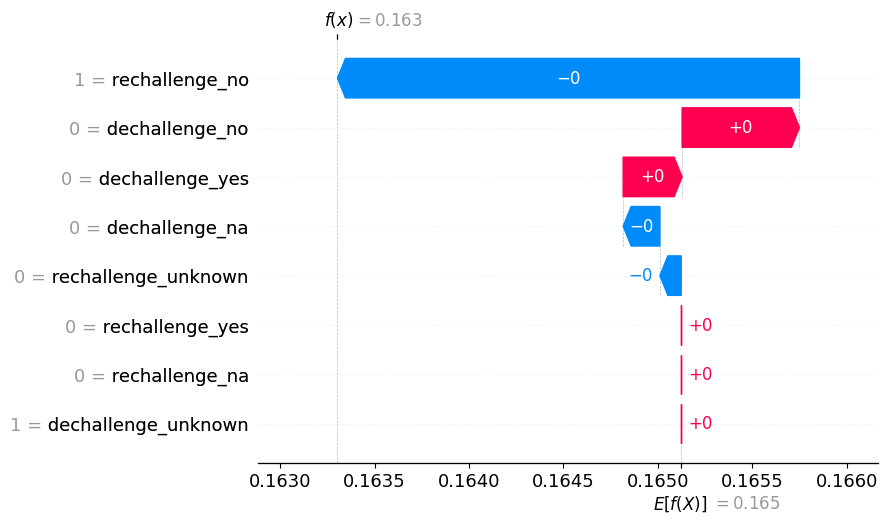

In [17]:
shap.plots.waterfall(shap_values_yt[0, :, 0])

shap.plots.waterfall(shap_values_yt[0, :, 1])

shap.plots.waterfall(shap_values_yt[0, :, 2])

shap.plots.waterfall(shap_values_yt[0, :, 3])

shap.plots.waterfall(shap_values_yt[0, :, 4])

shap.plots.waterfall(shap_values_yt[0, :, 5])

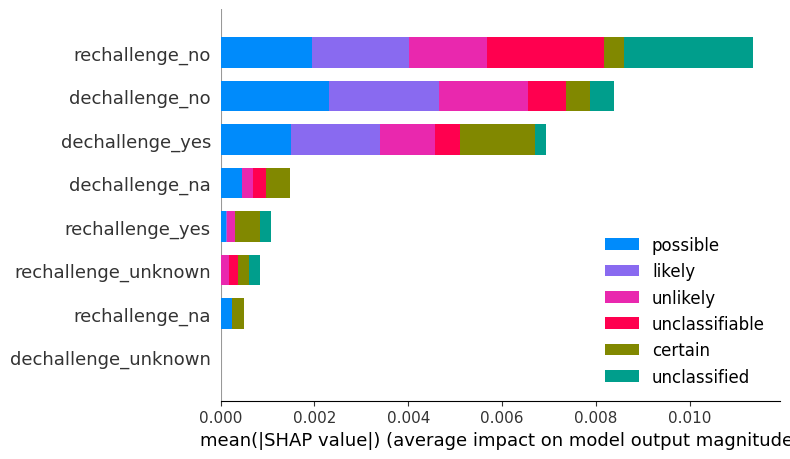

In [18]:
class_names = [
    "certain",
    "likely",
    "possible",
    "unlikely",
    "unclassified",
    "unclassifiable",
]

shap.summary_plot(
    shap_values,
    background_data_for_prediction.values,
    plot_type="bar",
    class_names=class_names,
    feature_names=background_data_for_prediction.columns,
)


In [19]:
# # summary plot of specific class
# shap.summary_plot(
#     shap_values[0],
#     background_data_for_prediction.values,
#     feature_names=background_data_for_prediction.columns,
# )

sum of shap values for each class. show how far each class was from becoming the predicted class. scaling 0,1